## 変更点

* exp2: coordを相対座標に

## 実験メモ

#### 12/26
* augumentationをするために、逐次マスクからcoordsに変換した方がいい
* 角度は、0と2piでズレがほとんどないのにlossが大きくなってしまうので、単位円上の座標が良さそう
* embeddingが無理？ embeddingは有限通りの入力をd_model次元で表現するものだから、従うためには有限通りの座標に落とし込む必要がある。となるとやはり角度が有利か。
* 座標でembeddingするには、どのパッチの上に乗っているかをidxで表して、それを埋め込むのが良さそう

#### 12/28
* ViTの実装ミスってた。アホすぎる

>推論時は、Greedyアルゴリズムの場合、再帰的に最初の単語から最後の単語まで一つづつ予測していきます（コード）。具体的には最初の推論でBOS（文章の始まり）のみを含む文章をターゲットとして、2個目の単語を予測します。そして予測した単語を含めて再度モデルを実行し、３個目の単語を予測します。このときモデルはソースであるドイツ語の文章と１〜２個目の英単語から３個目を予測することになります。これを繰り返し、モデルがEOS（文章の終わり）を出力するまで繰り返します。何番目の単語を予測するかで文章の長さが変わるのでtgt_maskは文章の長さを同じになるように値を設定します。

https://qiita.com/simayan/items/ea8bc5df150f7890d0e7

In [1]:
exp_name = 'angle_v3_baseline'

In [2]:
!python -V

import torch
import torch.nn as nn
import torchvision
import segmentation_models_pytorch


print(f'{torch.__version__}')
print(f'{torchvision.__version__}')
print(f'{segmentation_models_pytorch.__version__}')

torch.cuda.is_available(), torch.cuda.device_count()

Python 3.10.13
2.1.2
0.16.2
0.3.3


(True, 8)

***
## 本実装


In [3]:
import torchvision.models as models

# vit_b_16モデル呼び出し
model_vit = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

# get_model()
model_vit = models.get_model('vit_b_16', weights='DEFAULT')

model_vit.heads = torch.nn.Identity()
torch.save(model_vit.state_dict(), 'vit_b_224_16.pth')

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class CustomVisionTransformer(models.VisionTransformer):
    def __init__(self, *args, **kwargs):
        super(CustomVisionTransformer, self).__init__(*args, **kwargs)

        self.heads = torch.nn.Identity()
    
    def forward(self, x: torch.Tensor):
        # Reshape and permute the input tensor
        x = self._process_input(x)
        # print(f'_process_input: {x.shape=}')
        n = x.shape[0]

        # Expand the class token to the full batch
        batch_class_token = self.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)

        x = self.encoder(x)

        # 次の部分は一旦コメントあるとする、NLPにおけるtransformerと整合性があると思っているが、要確認
        # Classifier "token" as used by standard language architectures
        # x = x[:, 0]
        # print(f'return: {x.shape=}')
        return x

class CustomTransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(CustomTransformerDecoderLayer, self).__init__()
#         print(d_model, nhead)
        
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )

    def forward(self, tgt, memory, tgt_mask=None, tgt_pad_mask=None):
        """
        tgt: shape []
        """
        # Self attention with residual connection
        attn_output1, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_pad_mask)
        tgt = self.norm1(tgt + self.dropout(attn_output1))

        # Cross attention with residual connection
        attn_output2, attn_weights = self.multihead_attn(tgt, memory, memory)
#         attn_output2, attn_weights = self.multihead_attn(tgt, memory, memory, key_padding_mask=tgt_pad_mask)
        tgt = self.norm2(tgt + self.dropout(attn_output2))

        # Feed forward with residual connection
        ff_output = self.feed_forward(tgt)
        tgt = tgt + self.dropout(ff_output)

        return tgt

class CustomTransformerDecoder(nn.Module):
    def __init__(self, d_model, nhead, num_decoder_layers, target_vocab_size, pad_id=0):
        super(CustomTransformerDecoder, self).__init__()

        self.embedding = nn.Embedding(target_vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.decoder_layers = nn.ModuleList([CustomTransformerDecoderLayer(d_model, nhead) for _ in range(num_decoder_layers)])
        self.pad_id = pad_id

    def get_attn_subsequent_mask(self, sz: int) -> torch.Tensor:
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

    def forward(self, tgt, memory):
        tgt_pad_mask = (tgt == self.pad_id)
        tgt = self.embedding(tgt) # tgt_after_embedding: [batch, target_len, d_model]
        tgt = self.pos_encoder(tgt)
        
        # create masks, then pass to decoder
        batch_size, target_len, d_model = tgt.shape
        tgt_mask = self.get_attn_subsequent_mask(target_len)

        tgt_mask = tgt_mask.to(tgt.device)

        for i, layer in enumerate(self.decoder_layers):
            tgt = layer(tgt, memory, tgt_mask=tgt_mask, tgt_pad_mask=tgt_pad_mask)

        # [batch, target_len?, d_model]
        return tgt

class CoordsHead(nn.Module):
    def __init__(self):
        super(CoordsHead, self).__init__()

def get_sin_cos_torch(predict):
    deviations = predict - predict[predict != 0].reshape(-1, 2).mean(axis=0)
    norms = torch.linalg.vector_norm(deviations, axis=2)
    norms = norms + 0.00001
    norms_expanded = norms.unsqueeze(-1)
    sin_cos = deviations / norms_expanded
    return sin_cos

class CoordsViT(nn.Module):
    def __init__(self, image_size=224, patch_size=16, d_model=768, nhead=12, num_encoder_layers=12, num_decoder_layers=12, target_vocab_size=11, channels=3, out_channel=2):
        super(CoordsViT, self).__init__()

        # Encoder
        self.encoder = CustomVisionTransformer(
            image_size=image_size,
            patch_size=patch_size,
            num_layers=num_encoder_layers,
            num_heads=nhead,
            hidden_dim=d_model,
            mlp_dim=3072
        )
        self.encoder.load_state_dict(torch.load('vit_b_224_16.pth'))

        # Decoder
        self.decoder = CustomTransformerDecoder(d_model, nhead, num_decoder_layers, target_vocab_size)

        # Coords Head
        self.coords_heads = nn.Linear(d_model, out_channel)

    def forward(self, img, tgt):
        """
        tgt: [batch, target_len]
        """
        # Encode image
        encoder_output = self.encoder(img) # encoder_output: torch.Size([seq_len, batch, d_model])
        # print(f'encoder_output: {encoder_output.shape}')

        # Decode to get the target sequence
        tgt_out = self.decoder(tgt, encoder_output)  # tgt_out: [batch, target_len?, d_model]

        output = self.coords_heads(tgt_out)  # output: [batch, target_len?, 2], yx coords is 2d
        sin_cos = get_sin_cos_torch(output)
        angles = torch.rad2deg(torch.atan2(sin_cos[:, :, 0], sin_cos[:, :, 1]))
        return angles


In [31]:
import os
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from glob import glob

image_size = 224

class OneHotTensorEncode(object):
    def __init__(self, n_classes=10):
        self.n_classes = n_classes

    def __call__(self, mask, debug=False):
        """
        Convert a 1-channel grayscale PIL image with n_classes unique values 
        into an n_classes-channel one-hot encoded tensor.
        """

        mask = np.array(mask)
        one_hot = torch.zeros(self.n_classes, mask.shape[0], mask.shape[1], dtype=torch.float32)
        for i in range(self.n_classes):
            one_hot[i, :, :] = torch.tensor(mask == i, dtype=torch.float32)
            if debug:
                count = np.sum(mask == i)
                print(f"Number of pixels with value {i}: {count}")
            
                plt.imshow(one_hot[i, :, :].numpy(), cmap='gray')
                plt.title(f"Class {i} One-hot Encoded Channel")
                plt.colorbar()
                plt.show()
        return one_hot

class RandomTransformsDual:
    """
    画像とマスクの両方にランダム変換を適用するクラス
    """
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask):
        seed = np.random.randint(2147483647)  # 大きな数でランダムシードを設定
        np.random.seed(seed)  # 同じシードを使用して、画像とマスクの両方に同じ変換を確実に適用する

        for t in self.transforms:
            img = t(img)

        np.random.seed(seed)
        for t in self.transforms:
            mask = t(mask)

        return img, mask
    
def custom_crop(image, trim_margin=180):
    return image.crop((trim_margin, trim_margin, image.width - trim_margin, image.height - trim_margin))

def channelize(mask_array, n_classes=10):
    mask_10d = torch.zeros(n_classes, mask_array.shape[0], mask_array.shape[1], dtype=torch.float32)
    for i in range(n_classes): 
        mask_10d[i, :, :] = torch.tensor(mask == i, dtype=torch.float32)
    return mask_10d

def get_center_array(mask_10d, coord_filter, relative=False):
    coords = []
    for mask_i in mask_10d[1:]:
        if int(mask_i.sum()) == 0:
            coords.append([0, 0])
            continue
        center_yx = [int((mask_i * coord_filter[:, :, 0]).sum() / mask_i.sum()), int((mask_i * coord_filter[:, :, 1]).sum() / mask_i.sum())]
        if relative:
            center_yx[0] /= mask_i.shape[0]
            center_yx[1] /= mask_i.shape[1]
        coords.append(center_yx)
    assert len(coords) == len(mask_10d) - 1, 'dim incorrect'
    return torch.Tensor(coords)

def get_sin_cos(coords):
    deviations = coords - coords[coords != 0].reshape(-1, 2).mean(axis=0)
    norms = np.linalg.norm(deviations, axis=1)
    norms += 0.00001
    sin_cos = np.array([deviations.T[i] / norms for i in range(2)]).T
    sin_cos[coords == 0] = 0
    return sin_cos

class SegmentationDataset(Dataset):
    def __init__(self, image_glob_path, image_size, image_transforms=None, mask_transforms=None, random_transforms=None):
        self.image_glob_path = image_glob_path
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        self.random_transforms = random_transforms
        self.image_paths = sorted(glob(image_glob_path))
        self.coord_filter = np.array([[(i, j) for j in range(image_size)] for i in range(image_size)])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        mask_path = image_path.replace('/flw/', '/mask/')
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.random_transforms:
            image, mask = self.random_transforms(image, mask)

        if self.image_transforms:
            image = self.image_transforms(image)

        if self.mask_transforms:
            mask = self.mask_transforms(mask)
            coords = get_center_array(mask, self.coord_filter)
            sin_cos = get_sin_cos(coords)
            angles = np.degrees(np.arctan2(*sin_cos.T)).T
        return image, coords, angles

random_transforms = RandomTransformsDual([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(180)  # ±180度のランダムな回転
])

image_transforms = transforms.Compose([
    transforms.Lambda(custom_crop),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Lambda(custom_crop),
    transforms.Resize((image_size, image_size)),
    OneHotTensorEncode(n_classes=10),
])

flw_glob_path = '../../../../create_synthe_2023/synthetic_flw/flw/*/*'

# image_glob_path, mask_glob_path, image_transforms=None, mask_transforms=None, random_transforms=None):
dataset = SegmentationDataset(flw_glob_path, image_size, image_transforms=image_transforms, mask_transforms=mask_transforms)
dataset_size = len(dataset)

train_ratio = 0.7
val_ratio = 0.3

train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
# test_size = dataset_size - train_size - val_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# データローダーの作成
batch_size = 32
num_workers = 48
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [32]:
import math
import torch
import torch.nn as nn

from tqdm import tqdm
import segmentation_models_pytorch.utils as smp_utils

patch_size = 16
num_patch_1d = (image_size // patch_size)
indexer_1d = np.array([num_patch_1d, 1])

d_model = 256
nhead = 8
num_encoder_layers = 3
num_decoder_layers = 3
target_vocab_size = num_patch_1d ** 2 # patchの数を語彙数とする
# len_out_seq = 9

model = CoordsViT(target_vocab_size=target_vocab_size)

for i, (images, coords, angles) in enumerate(train_dataloader):
    coords_idx_2d = coords // num_patch_1d
    coords_idx_1d = coords_idx_2d @ indexer_1d
    target_seq = coords_idx_1d.long()
    break

output = model(images, target_seq)

print(f'target_seq.shape: {target_seq.shape}')
print(f'output.shape: {output.shape}')

target_seq.shape: torch.Size([32, 9])
output.shape: torch.Size([32, 9])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


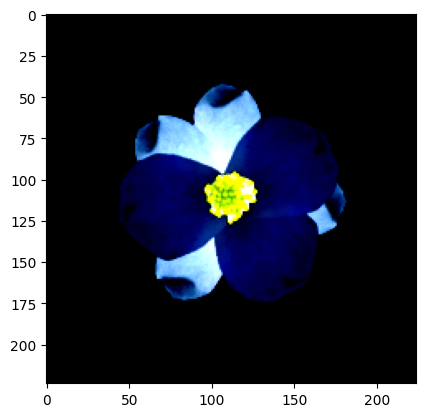

In [33]:
import matplotlib.pyplot as plt
plt.imshow(torch.permute(images[0], (1, 2, 0)))
plt.show()

In [ ]:
# device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    save_path = f'./models/{exp_name}_epoch{epoch + 1}.pth'
    if os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))
        continue
    with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}, Train") as pbar_train:
        for i, (images, coords, angles) in enumerate(train_dataloader):
            images = images.to(device)
            coords_idx_2d = coords // num_patch_1d
            coords_idx_1d = coords_idx_2d @ indexer_1d
            target_seq = coords_idx_1d.long().to(device)

            output = model(images, target_seq)
            loss = criterion(output, angles.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar_train.set_postfix({"Train Loss": loss.item()})
            pbar_train.update(1)

    torch.save(model.state_dict(), save_path)

    model.eval()
    with torch.no_grad():
        with tqdm(total=len(val_dataloader), desc=f"Epoch {epoch + 1} / {num_epochs}, Val") as pbar_val:
            for i, (images, coords, angles) in enumerate(val_dataloader):
                images = images.to(device)
                coords_idx_2d = coords // num_patch_1d
                coords_idx_1d = coords_idx_2d @ indexer_1d
                target_seq = coords_idx_1d.long().to(device)
    
                output = model(images, target_seq)
                loss = criterion(output, angles.to(device))
    
                pbar_val.set_postfix({"Val Loss": loss.item()})
                pbar_val.update(1)


Epoch 1/200, Train:  26%|██▌       | 2866/10938 [32:28<1:29:42,  1.50it/s, Train Loss=7.91e+3]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/200, Train:  60%|█████▉    | 6532/10938 [1:12:52<48:54,  1.50it/s, Train Loss=1.06e+4]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 12/200, Train:  40%|███▉      | 4349/10938 [48:43<1:12:57,  1.51it/s, Train Loss=8.47e+3]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending

***

## 諸々の確認

In [12]:
print(f'{output.shape=}, {angles.shape=}')

output.shape=torch.Size([32, 9]), angles.shape=torch.Size([32])


In [11]:
print(f

angles.shape=torch.Size([32])


In [9]:
print(f'{output.shape=}')

torch.Size([16, 9, 2])

In [12]:
output[0]

tensor([[ 0.0005, -0.0038],
        [ 0.0005, -0.0038],
        [ 0.0005, -0.0038],
        [ 0.0005, -0.0038],
        [ 0.0005, -0.0038],
        [ 0.0005, -0.0038],
        [ 0.0005, -0.0038],
        [ 0.0005, -0.0038],
        [ 0.0005, -0.0038]], device='cuda:0', grad_fn=<SelectBackward0>)

In [13]:
sin_cos[0]

tensor([[-0.9960,  0.0897],
        [-0.1261, -0.9920],
        [ 0.9999,  0.0171],
        [ 0.0846,  0.9964],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]])

In [17]:
model.decoder.get_attn_subsequent_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [18]:
model.decoder.decoder_layers[0]

CustomTransformerDecoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (feed_forward): Sequential(
    (0): Linear(in_features=768, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=2048, out_features=768, bias=True)
  )
)

In [26]:
model.eval()
with torch.no_grad():
    for i, (images, coords, sin_cos) in enumerate(val_dataloader):
        images = images.to(device)
        coords_idx_2d = coords // num_patch_1d
        coords_idx_1d = coords_idx_2d @ indexer_1d
        target_seq = coords_idx_1d.long().to(device)

        # model(images, target_seq)
        tgt = target_seq
        encoder_output = model.encoder(images)
        tgt_out = model.decoder(tgt, encoder_output)  # tgt_out: [batch, target_len?, d_model]
        output = model.coords_heads(tgt_out)  # output: [batch, target_len?, 2], yx coords is 2d
        
        loss = criterion(output, sin_cos.to(device))
        break
output[0]

tensor([[ 0.0008, -0.0032],
        [ 0.0008, -0.0032],
        [ 0.0008, -0.0032],
        [ 0.0008, -0.0032],
        [ 0.0008, -0.0032],
        [ 0.0008, -0.0032],
        [ 0.0008, -0.0032],
        [ 0.0008, -0.0032],
        [ 0.0008, -0.0032]], device='cuda:0')

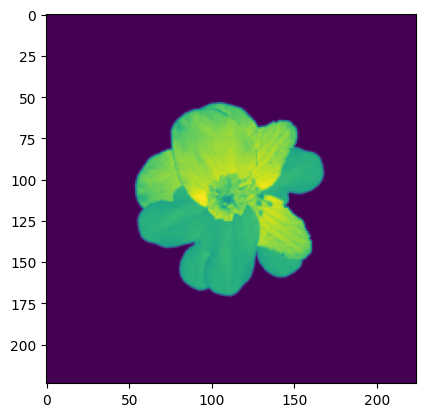

In [38]:
import matplotlib.pyplot as plt
showimg = np.array(images[0][0].cpu())
plt.imshow(showimg)


In [42]:
encoder_output[0]

tensor([[ 193.2596,  111.6764,  146.5872,  ...,  194.4211,  -39.3381,
         -140.3569],
        [ 193.2596,  111.6764,  146.5872,  ...,  194.4211,  -39.3381,
         -140.3569],
        [ 193.2596,  111.6764,  146.5872,  ...,  194.4211,  -39.3381,
         -140.3569],
        ...,
        [ 193.2596,  111.6764,  146.5872,  ...,  194.4211,  -39.3381,
         -140.3569],
        [ 193.2596,  111.6764,  146.5872,  ...,  194.4211,  -39.3381,
         -140.3569],
        [ 193.2596,  111.6764,  146.5872,  ...,  194.4211,  -39.3381,
         -140.3569]], device='cuda:0')

In [ ]:
    def forward(self, tgt, memory, tgt_mask=None, tgt_pad_mask=None):
        """
        tgt: shape []
        """
        # Self attention with residual connection
        attn_output1, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_pad_mask)
        tgt = self.norm1(tgt + self.dropout(attn_output1))

        # Cross attention with residual connection
        attn_output2, attn_weights = self.multihead_attn(tgt, memory, memory)
#         attn_output2, attn_weights = self.multihead_attn(tgt, memory, memory, key_padding_mask=tgt_pad_mask)
        tgt = self.norm2(tgt + self.dropout(attn_output2))

        # Feed forward with residual connection
        ff_output = self.feed_forward(tgt)
        tgt = tgt + self.dropout(ff_output)

        return tgt

class CustomTransformerDecoder(nn.Module):
    def __init__(self, d_model, nhead, num_decoder_layers, target_vocab_size, pad_id=0):
        super(CustomTransformerDecoder, self).__init__()

        self.embedding = nn.Embedding(target_vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.decoder_layers = nn.ModuleList([CustomTransformerDecoderLayer(d_model, nhead) for _ in range(num_decoder_layers)])
        self.pad_id = pad_id

    def get_attn_subsequent_mask(self, sz: int) -> torch.Tensor:
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

    def forward(self, tgt, memory):
        tgt_pad_mask = (tgt == self.pad_id)
        tgt = self.embedding(tgt) # tgt_after_embedding: [batch, target_len, d_model]
        tgt = self.pos_encoder(tgt)
        
        # create masks, then pass to decoder
        batch_size, target_len, d_model = tgt.shape
        tgt_mask = self.get_attn_subsequent_mask(target_len)

        tgt_mask = tgt_mask.to(tgt.device)

        for i, layer in enumerate(self.decoder_layers):
            tgt = layer(tgt, memory, tgt_mask=tgt_mask, tgt_pad_mask=tgt_pad_mask)

        # [batch, target_len?, d_model]
        return tgt


In [ ]:
for channel in cross_attention_maps.to('cpu')[0]:
    print(channel)
    break

In [ ]:
for channel in mask_proportions.to('cpu')[0]:
    print(channel)
    break

In [ ]:
for i in 

In [ ]:
predicted_indices = torch.argmax(pred_probs, dim=-1)
predicted_indices

In [ ]:
loss_mask

In [ ]:
loss_seq

In [ ]:
predicted_indices = torch.argmax(pred_probs, dim=-1)
predicted_indices

In [ ]:
loss_seq

In [ ]:
loss_mask

In [19]:
loss_seq

tensor(0.7469, device='cuda:2')

In [13]:
import torch.nn.functional as F
print(predicted_indices.shape)
pred_one_hot = F.one_hot(predicted_indices).float()
gt_one_hot = F.one_hot(target_seq).float()
loss = F.binary_cross_entropy_with_logits(pred_one_hot, gt_one_hot)

print(loss)

torch.Size([12, 11])
tensor(0.7357)


In [9]:
target_seq

tensor([[ 0,  1,  2,  3,  4,  5, 10, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5, 10, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 10],
        [ 0,  1,  2,  3,  4,  5, 10, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5, 10, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7, 10, 10, 10]])

In [ ]:
import torch
import matplotlib.pyplot as plt

def recreate_image_from_attention(cross_attention_map, img_size, patch_size):
    """
    cross_attention_map: shape [11, 1024] (or any [channel_out, flattened_img_size])
    img_size: Original image size (e.g., 224 for a 224x224 image)
    patch_size: The size of each patch (e.g., 16 for 16x16 patches)
    """
    channel_out, flattened_img_size = cross_attention_map.shape
    patches_per_dim = img_size // patch_size
    
    # Reshape to [channel_out, patches_per_dim, patches_per_dim]
    reshaped_attention_map = cross_attention_map.view(channel_out, patches_per_dim, patches_per_dim)
    
    # Initialize tensor to store the recreated image
    recreated_images = torch.zeros((channel_out, img_size, img_size))
    
    # Fill in the recreated image tensor
    for i in range(patches_per_dim):
        for j in range(patches_per_dim):
            recreated_images[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = reshaped_attention_map[:, i, j].unsqueeze(1).unsqueeze(2)
            
    return recreated_images


# Call the function
recreated_images = recreate_image_from_attention(cross_attention_maps[0][0], image_size, patch_size)

# Visualize
for i in range(recreated_images.shape[0]):
    plt.figure()
    plt.imshow(recreated_images[i].detach().numpy(), cmap="gray")
    plt.title(f"Channel {i}")
    plt.show()


In [ ]:
recreated_images = recreate_image_from_attention(mask_proportions[0], image_size, patch_size)

# Visualize
for i in range(recreated_images.shape[0]):
    plt.figure()
    plt.imshow(recreated_images[i].detach().numpy(), cmap="gray")
    plt.title(f"Channel {i}")
    plt.show()


## Idea 



* クラスラベルの順列を出力系列とするのは、あまりに難しそう。
* docoderに入力するのは、各パッチの特徴を並べたもの

target_seqの系列長と最終的に出力してほしいsequence_lengthは一般には同じである必要はありません。Transformerモデルの訓練時においては、通常、ターゲット系列（target_seq）は入力として使われるだけでなく、訓練のラベルとしても使用されます。その場合、target_seqの系列長は出力と一致するように設計されることが多いです。

しかし、推論（予測）時には、通常、開始トークンだけをtarget_seqとして使用し、モデルがその後のトークンを一つずつ生成するようにします。この場合、target_seqの初期の長さは1であり、出力のsequence_lengthは1から始まって任意の長さになり得ます（停止条件または最大長に達するまで）。

簡単に言うと、訓練と推論でtarget_seqの役割が少し異なるため、その長さもそれに応じて変わります。

In [52]:
predicted_indices = torch.argmax(output, dim=-1)
predicted_indices.shape == target_seq.shape

True